In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pyedflib

import matplotlib.pyplot as plt
%matplotlib inline

import sklearn 
import keras
import numpy as np
import os
import os.path as osp

Using TensorFlow backend.


In [3]:
EEG_DATA = '/Users/aelphy/Downloads/files/'

open_eyes = []
closed_eyes = []
for session in os.listdir(EEG_DATA):
    if session.startswith('S') and not session.endswith('.txt'):
        fopen = pyedflib.EdfReader(osp.join(EEG_DATA, session, session + 'R01.edf'))
        fclosed = pyedflib.EdfReader(osp.join(EEG_DATA, session, session + 'R02.edf'))
        
        for i, f in enumerate([fopen, fclosed]):
            n = f.signals_in_file
            signal_labels = f.getSignalLabels()
            sigbufs = np.zeros((n, f.getNSamples()[0]))
            for j in np.arange(n):
                sigbufs[j, :] = f.readSignal(j)
            [open_eyes, closed_eyes][i].append(sigbufs[None, ..., :9600])

In [4]:
open_eyes = np.concatenate(open_eyes)
closed_eyes = np.concatenate(closed_eyes)
X = np.concatenate([open_eyes, closed_eyes])
labels = np.concatenate([np.zeros(len(open_eyes)), np.ones(len(closed_eyes))])

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, labels)

In [7]:
from sklearn.manifold import TSNE

In [8]:
X_embedded = TSNE(n_components=2).fit_transform(X_train.reshape(len(X_train), -1))

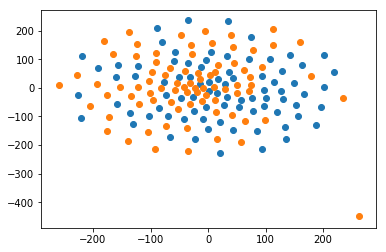

In [9]:
plt.scatter(X_embedded[:, 0][y_train == 0], X_embedded[:, 1][y_train == 0])
plt.scatter(X_embedded[:, 0][y_train == 1], X_embedded[:, 1][y_train == 1])

In [10]:
from sklearn.preprocessing import StandardScaler
sc1 = StandardScaler()

In [11]:
X_train_shape = X_train.shape
X_val_shape = X_val.shape
X_train_scaled = sc1.fit_transform(X_train.reshape(-1, 1)).reshape(X_train_shape).transpose(0, 2, 1)
X_val_scaled = sc1.transform(X_val.reshape(-1, 1)).reshape(X_val_shape).transpose(0, 2, 1)
X_train_scaled = X_train.transpose(0, 2, 1)
X_val_scaled = X_val.transpose(0, 2, 1)

In [13]:
import tntorch as tn
import torch

In [14]:
tt = tn.Tensor(X_train.reshape(X_train.shape[0], X_train.shape[1], *[10, 10, 96]), ranks_tt=20, batch=True)
tt_val = tn.Tensor(X_val.reshape(X_val.shape[0], X_val.shape[1], *[10, 10, 96]), ranks_tt=20, batch=True)
train_cores = [core.reshape(len(core), -1) for core in tt.cores]
val_cores = [core.reshape(len(core), -1) for core in tt_val.cores]
[core.shape for core in train_cores], [core.shape for core in val_cores]

([torch.Size([163, 1280]),
  torch.Size([163, 4000]),
  torch.Size([163, 4000]),
  torch.Size([163, 1920])],
 [torch.Size([55, 1280]),
  torch.Size([55, 4000]),
  torch.Size([55, 4000]),
  torch.Size([55, 1920])])

In [15]:
def iterate_minibatches(l, batch_size, shuffle=True):
    idxs = np.arange(l)
    if shuffle:
        np.random.shuffle(idxs)

    if batch_size > l:
        yield idxs
        return
        
    for start_idx in range(0, l, batch_size):
        excerpt = idxs[start_idx:start_idx + batch_size]
        yield excerpt

In [18]:
import math
import torch
from torch.optim.optimizer import Optimizer, required

class RAdam(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = group['lr'] / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:            
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

class PlainRAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)

        super(PlainRAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(PlainRAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                beta2_t = beta2 ** state['step']
                N_sma_max = 2 / (1 - beta2) - 1
                N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:                    
                    step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    step_size = group['lr'] / (1 - beta1 ** state['step'])
                    p_data_fp32.add_(-step_size, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss


class AdamW(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, warmup = 0):
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, warmup = warmup)
        super(AdamW, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AdamW, self).__setstate__(state)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                denom = exp_avg_sq.sqrt().add_(group['eps'])
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                
                if group['warmup'] > state['step']:
                    scheduled_lr = 1e-8 + state['step'] * group['lr'] / group['warmup']
                else:
                    scheduled_lr = group['lr']

                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1
                
                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * scheduled_lr, p_data_fp32)

                p_data_fp32.addcdiv_(-step_size, exp_avg, denom)

                p.data.copy_(p_data_fp32)

        return loss

In [22]:
clf = TTClassifier(train_cores, 2, device='cpu')
optimizer = RAdam(list(clf.parameters()), lr=1e-3)

In [21]:
import torch.nn.functional as F
import torch.nn as nn
import torch
import numpy as np

class TTClassifier(nn.Module):
    def __init__(self, cores, num_classes, device='cpu'):
        super(TTClassifier, self).__init__()
                
        self.inpts = [None] * len(cores)        
        lens = [None] * len(cores)
        for i, core in enumerate(cores):
            lens[i] = np.prod(core.shape[1:])
            self.inpts[i] = nn.Sequential(
                nn.Linear(lens[i], 2 * lens[i]),
                nn.Tanh()
            ).to(device)
        
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(2 * np.sum(lens), 500),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(500, 250),
            nn.ReLU(inplace=True),
            nn.Linear(250, num_classes)
        )

    def forward(self, x):
        inpts = [None] * len(x)
        for i, core in enumerate(x):
            inpts[i] = self.inpts[i](core)

        return self.classifier(torch.cat(inpts, dim=1))

In [85]:
def compute_CE(orig, pred):
    return torch.nn.functional.cross_entropy(pred, orig)

In [92]:
failed = set()
batch_size = 32
num_epochs = 10
eval_every = 1

for j in range(num_epochs):
    counter = 0
    counter_val = 0
    ce_val = 0
    ce_train = 0
    loss = 0
    loss_val = 0

    clf.train()
    for idxs in iterate_minibatches(len(X_train), batch_size):
        optimizer.zero_grad()

        cores = [core[idxs] for core in train_cores]
        clf_preds = clf(cores)

        ce_loss_batch = compute_CE(torch.tensor(y_train[idxs]).long(), clf_preds)

        loss_batch = ce_loss_batch

        try:
            loss_batch.backward()
            optimizer.step()

            counter += 1
            loss += loss_batch.detach().cpu().numpy()
            ce_train += ce_loss_batch.detach().cpu().numpy()
        except:
            for idx in idxs:
                failed.add(idx)

    if (j + 1) % eval_every == 0:
        clf.eval()
        for idxs in iterate_minibatches(len(X_val), batch_size):
            cores = [core[idxs] for core in val_cores]
            clf_preds = clf(cores)

            ce_loss_batch = compute_CE(torch.tensor(y_val[idxs]).long(), clf_preds)

            loss_batch = ce_loss_batch

            counter_val += 1
            loss_val += loss_batch.detach().cpu().numpy()
            ce_val += ce_loss_batch.detach().cpu().numpy()
            
        print('Epoch {}:'.format(j + 1))
        print('\t TRAIN LOSS={}'.format(loss / counter))
        print('\t VAL LOSS={}'.format(loss_val / counter_val))
        print('\t FAILED {}'.format(len(failed)))

Epoch 1:
	 TRAIN LOSS=0.6968722105026245
	 VAL LOSS=0.7033094763755798
	 FAILED 0
Epoch 2:
	 TRAIN LOSS=0.686477255821228
	 VAL LOSS=0.6756517291069031
	 FAILED 0
Epoch 3:
	 TRAIN LOSS=0.6521947383880615
	 VAL LOSS=0.6520096659660339
	 FAILED 0
Epoch 4:
	 TRAIN LOSS=0.6065455794334411
	 VAL LOSS=0.6098774671554565
	 FAILED 0
Epoch 5:
	 TRAIN LOSS=0.5390273213386536
	 VAL LOSS=0.5940300226211548
	 FAILED 0
Epoch 6:
	 TRAIN LOSS=0.49159618020057677
	 VAL LOSS=0.6322389841079712
	 FAILED 0
Epoch 7:
	 TRAIN LOSS=0.45858129262924197
	 VAL LOSS=0.5036295652389526
	 FAILED 0
Epoch 8:
	 TRAIN LOSS=0.4051064014434814
	 VAL LOSS=0.6640836000442505
	 FAILED 0
Epoch 9:
	 TRAIN LOSS=0.34034051895141604
	 VAL LOSS=0.45472729206085205
	 FAILED 0
Epoch 10:
	 TRAIN LOSS=0.28474880158901217
	 VAL LOSS=0.5494940280914307
	 FAILED 0


In [156]:
clf.eval()
preds = []
labs = []
for idxs in iterate_minibatches(len(X_val), batch_size, shuffle=False):
    cores = [core[idxs] for core in val_cores]
    clf_preds = clf(cores)
    preds.append(torch.argmax(torch.softmax(clf_preds, dim=1), dim=1))
    labs.append(torch.tensor(y_val[idxs]).long())

In [159]:
(torch.cat(preds) == torch.cat(labs)).sum().float() / len(torch.cat(preds))

tensor(0.7455)